# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline


import re
import seaborn as sns
import time


# magic word for producing visualizations in notebook
%matplotlib inline



## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

print('Number of columns: ', azdias.shape[1])
print('Number of rows: ', azdias.shape[0])
azdias.head()

Number of columns:  366
Number of rows:  891221


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
# Get information about azdias data
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [5]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


### Identify missing or unknown data values

In this part I will be using feature file provided for Term 1 - 'AZDIAS_Feature_Summary.csv' and feature file 'DIAS Attributes - Values 2017.xlsx' (Term 2) to find the meaning of missing or unknown values.

In [3]:
# Identify missing or unknown data values in azdias data 
col_null = azdias.isnull().sum()

# Find statistics about missing values 
col_null[col_null != 0]
col_null.describe()
#print(col_null.idxmax(), azdias['EXTSEL992'].isnull().sum()/azdias.shape[0])


count       366.000000
mean      91510.718579
std      108408.554865
min           0.000000
25%           0.000000
50%      105800.000000
75%      107151.500000
max      890016.000000
dtype: float64

In [4]:

print("Total number of missing data: ", sum(col_null))


Total number of missing data:  33492923


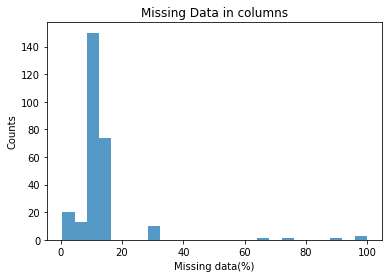

In [4]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
col_null_updated = azdias.isnull().sum()[azdias.isnull().sum() != 0]
plt.hist((col_null_updated/azdias.shape[0])*100, bins=25, alpha=0.75)
plt.xlabel('Missing data(%)')
plt.ylabel('Counts')
plt.title('Missing Data in columns')
plt.grid(False)
plt.show()

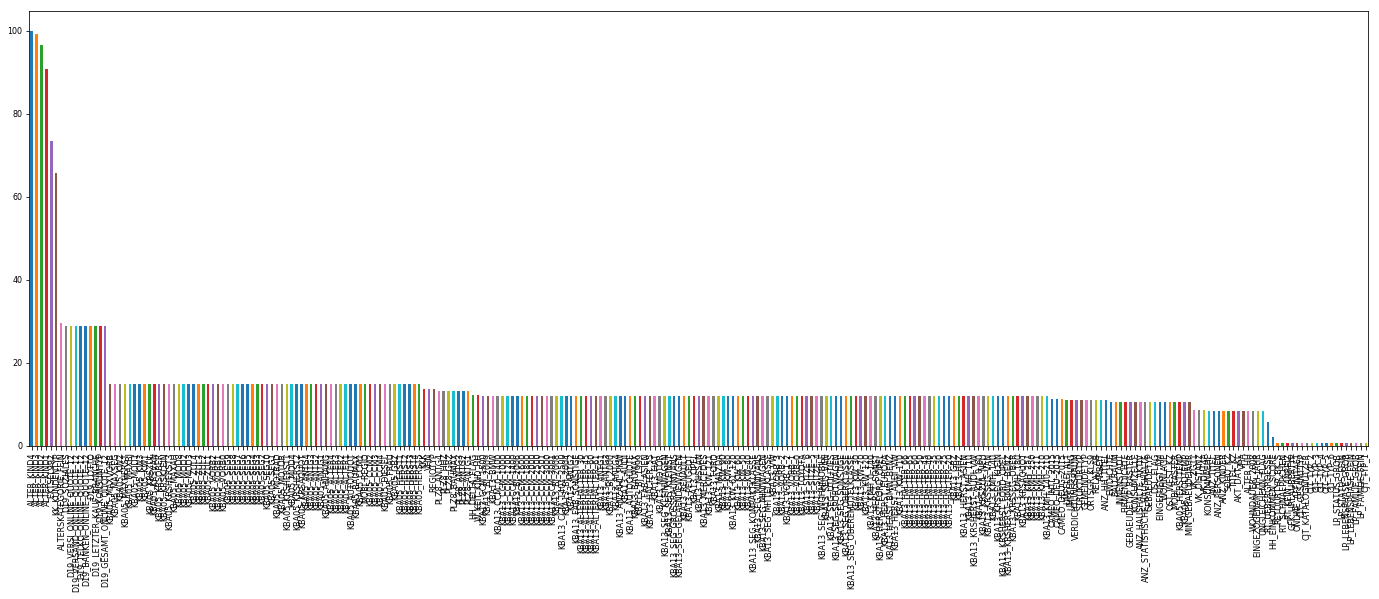

In [9]:
# Investigate patterns in the amount of missing data in each column.
(col_null_updated/azdias.shape[0]*100).sort_values(ascending=False).plot.bar(figsize=(24,8), fontsize=8);

In [4]:
# Load feature attributes files from Term 1 and Term 2 and find missing and unknown values in both files

feat_list_old = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
feat_list_old.shape


(85, 4)

In [5]:
# Keep only not empty missing values
feat_old = feat_list_old[feat_list_old['missing_or_unknown'] != '[]']


In [6]:
# Closer look at Attributes file structure
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols="B, D:E")
feat_info.head(10)

,Attribute,Value,Meaning
0,AGER_TYP,-1,unknown
1,NaN,0,no classification possible
2,NaN,1,passive elderly
3,NaN,2,cultural elderly
4,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,"-1, 0",unknown
6,NaN,1,< 30 years
7,NaN,2,30 - 45 years
8,NaN,3,46 - 60 years
9,NaN,4,> 60 years


In [8]:
np.setdiff1d(list(feat_info['Attribute'].unique()), azdias.columns)

array(['BIP_FLAG', 'CAMEO_DEUINTL_2015', 'D19_BANKEN_DIREKT_RZ',
       'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_REST_RZ',
       'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG_RZ',
       'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ',
       'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ',
       'D19_GARTEN_RZ', 'D19_HANDWERK_RZ', 'D19_HAUS_DEKO_RZ',
       'D19_KINDERARTIKEL_RZ', 'D19_KK_KUNDENTYP', 'D19_KOSMETIK_RZ',
       'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_RZ', 'D19_NAHRUNGSERGAENZUNG_RZ',
       'D19_RATGEBER_RZ', 'D19_REISEN_RZ', 'D19_SAMMELARTIKEL_RZ',
       'D19_SCHUHE_RZ', 'D19_SONSTIGE_RZ', 'D19_TECHNIK_RZ',
       'D19_TELKO_MOBILE_RZ', 'D19_TELKO_REST_RZ', 'D19_TIERARTIKEL_RZ',
       'D19_VERSAND_REST_RZ', 'D19_VERSICHERUNGEN_RZ',
       'D19_VOLLSORTIMENT_RZ', 'D19_WEIN_FEINKOST_RZ', 'GEOSCORE_KLS7',
       'HAUSHALTSSTRUKTUR', 'KBA13_CCM_1400_2500', 'SOHO_FLAG',
       'WACHSTUMSGEBIET_NB', 'nan'], 
      dtype='<

In [7]:
# exctract only unknown values from the "Meaning" column and fill "Attribute" column with previous value 
#if we have two or more unknown values for that attribute
feat_info_new_missing = feat_info.loc[(feat_info['Meaning'].str.contains("unknown") | feat_info['Meaning'].str.contains("no "))].reset_index(drop=True)
feat_info_new_missing['Attribute'] = feat_info_new_missing['Attribute'].ffill()

feat_info_new_missing.head()

,Attribute,Value,Meaning
0,AGER_TYP,-1,unknown
1,AGER_TYP,0,no classification possible
2,ALTERSKATEGORIE_GROB,"-1, 0",unknown
3,ALTER_HH,0,unknown / no main age detectable
4,ANREDE_KZ,"-1, 0",unknown


In [23]:
azdias['ALTERSKATEGORIE_GROB'].unique()

array([2, 1, 3, 4, 9])

In [10]:
feat_old.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
# Find what columns are from Term 1 file are in Term 2 file. 
feat_old_in_feat_info = np.intersect1d(feat_old['attribute'], feat_info_new_missing['Attribute'].unique())
len(feat_old_in_feat_info)

59

In [20]:
#feat_info_updatted = feat_info_new_missing[~feat_info_new_missing['Attribute'].isin(feat_old_in_feat_info)].reset_index(drop=True)
#print(feat_info_updatted.shape)

In [12]:
#test
feat_info_new_missing.loc[feat_info_new_missing['Attribute']== 'BIP_FLAG', 'Value'].astype(str)

6    -1
7     0
Name: Value, dtype: object

In [9]:
# Combine unknown values in one cell for each attribute in the format of Term 1 file 
# and make Unknown values dataframe
unknown_values = []
for attribute in feat_info_new_missing['Attribute'].unique():
    _ = feat_info_new_missing.loc[feat_info_new_missing['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',')
    unknown_values.append('['+_+']')   

unknown_values = pd.concat([pd.Series(feat_info_new_missing['Attribute'].unique()), pd.Series(unknown_values)], axis=1)
unknown_values.columns = ['attribute', 'missing_or_unknown']
unknown_values.head()

,attribute,missing_or_unknown
0,AGER_TYP,"[-1,0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


In [10]:
# Keep only Term 2 attributes, not Term 1 attributes
feat_info_updatted = unknown_values[~unknown_values['attribute'].isin(feat_old_in_feat_info)].reset_index(drop=True)
feat_info_updatted.head(10)


,attribute,missing_or_unknown
0,BIP_FLAG,"[-1,0]"
1,CAMEO_DEUINTL_2015,[-1]
2,D19_BANKEN_ANZ_12,[0]
3,D19_BANKEN_ANZ_24,"[0,10]"
4,D19_BANKEN_DIREKT_RZ,[0]
5,D19_BANKEN_GROSS_RZ,[0]
6,D19_BANKEN_LOKAL_RZ,"[0,10,10]"
7,D19_BANKEN_ONLINE_QUOTE_12,[0]
8,D19_BANKEN_REST_RZ,[0]
9,D19_BEKLEIDUNG_GEH_RZ,[0]


In [11]:
feat_info_updatted.shape, unknown_values.shape

((219, 2), (278, 2))

In [12]:

feat_info_updatted['attribute']=feat_info_updatted['attribute'].apply(lambda x: re.sub('_RZ$', '', x))
print(feat_info_updatted.shape)
feat_info_updatted.head()

(219, 2)


,attribute,missing_or_unknown
0,BIP_FLAG,"[-1,0]"
1,CAMEO_DEUINTL_2015,[-1]
2,D19_BANKEN_ANZ_12,[0]
3,D19_BANKEN_ANZ_24,"[0,10]"
4,D19_BANKEN_DIREKT,[0]


In [13]:
# Combine both Term 1 and Term 2 attributes in one dataframe
feat_info_all = pd.concat([feat_old, feat_info_updatted], join= 'inner').sort_values(by='attribute').reset_index(drop=True)
feat_info_all.head()

,attribute,missing_or_unknown
0,AGER_TYP,"[-1,0]"
1,ALTERSKATEGORIE_GROB,"[-1,0,9]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1,0]"
4,ANZ_HAUSHALTE_AKTIV,[0]


In [16]:
feat_info_all.shape
feat_info_all.set_index('attribute', inplace=True)
#feat_list_old.loc[feat_list_old['attribute'] == 'ANZ_HH_TITEL']

## Convert missing or unknown values to NaNs


In this part I use help functions from Term 1 to convert missing or unknown values to NaNs. Also, I take closer look at available description on columns in azdias data.


In [14]:
# From Term 1
# Help functions to convert missing or unknown values to NaNs
def is_valid_decimal(s):
    try:
        int(s)
    except ValueError:
        return False
    else:
        return True
    
def convert_to_types(source):
    return list(map(lambda x: int(x) if is_valid_decimal(x) else x, source[1:-1].split(',')))


In [33]:
# test
print('ANZ_HH_TITEL' in feat_old['attribute'])
feat_info_all.head(1)

False


,missing_or_unknown
attribute,
AGER_TYP,"[-1,0]"


In [156]:
feat_info_all.shape, feat_list_old.shape, feat_old.shape, azdias.shape[1]

((294, 2), (85, 4), (75, 4), 366)

In [34]:
# From Term 1
# Convert missing or unknown to NaNs
for column in azdias.columns:
    if column in feat_info_all.index:
        azdias[column] = azdias[column].replace(convert_to_types(feat_info_all.loc[column].missing_or_unknown), np.nan)
    elif azdias[column].dtype == np.int64:
        azdias[column]= azdias[column].astype(np.float64)
    else:
        continue                

In [35]:
# Find columns with no information an both attributes files
#feat_list = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', usecols="C")


azdias_columns_not_in_feat = np.setdiff1d(np.setdiff1d(azdias.columns, list(feat_info['Attribute'].unique())), feat_info_all.index)
print("Azdias columns with no description in the feature file: \n", azdias_columns_not_in_feat, len(azdias_columns_not_in_feat))

Azdias columns with no description in the feature file: 
 ['AKT_DAT_KL' 'ALTERSKATEGORIE_FEIN' 'ALTER_KIND1' 'ALTER_KIND2'
 'ALTER_KIND3' 'ALTER_KIND4' 'ANZ_KINDER' 'ANZ_STATISTISCHE_HAUSHALTE'
 'CJT_KATALOGNUTZER' 'CJT_TYP_1' 'CJT_TYP_2' 'CJT_TYP_3' 'CJT_TYP_4'
 'CJT_TYP_5' 'CJT_TYP_6' 'D19_BUCH_CD' 'D19_KONSUMTYP_MAX'
 'D19_LETZTER_KAUF_BRANCHE' 'D19_SOZIALES' 'D19_TELKO_ONLINE_QUOTE_12'
 'D19_VERSI_DATUM' 'D19_VERSI_OFFLINE_DATUM' 'D19_VERSI_ONLINE_DATUM'
 'D19_VERSI_ONLINE_QUOTE_12' 'DSL_FLAG' 'EINGEFUEGT_AM'
 'EINGEZOGENAM_HH_JAHR' 'EXTSEL992' 'FIRMENDICHTE' 'GEMEINDETYP'
 'HH_DELTA_FLAG' 'KBA13_ANTG1' 'KBA13_ANTG2' 'KBA13_ANTG3' 'KBA13_ANTG4'
 'KBA13_BAUMAX' 'KBA13_CCM_1401_2500' 'KBA13_GBZ' 'KBA13_HHZ'
 'KBA13_KMH_210' 'KOMBIALTER' 'KONSUMZELLE' 'LNR' 'MOBI_RASTER'
 'RT_KEIN_ANREIZ' 'RT_SCHNAEPPCHEN' 'RT_UEBERGROESSE' 'STRUKTURTYP'
 'UMFELD_ALT' 'UMFELD_JUNG' 'UNGLEICHENN_FLAG' 'VERDICHTUNGSRAUM' 'VHA'
 'VHN' 'VK_DHT4A' 'VK_DISTANZ' 'VK_ZG11'] 57


In [36]:
columns_no_info_to_drop = set(azdias_columns_not_in_feat) - set(['CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5','CJT_TYP_6'])
print(columns_no_info_to_drop, len(columns_no_info_to_drop))

{'KBA13_GBZ', 'KBA13_ANTG3', 'D19_KONSUMTYP_MAX', 'KOMBIALTER', 'RT_SCHNAEPPCHEN', 'VK_DHT4A', 'KBA13_KMH_210', 'RT_UEBERGROESSE', 'KONSUMZELLE', 'KBA13_ANTG2', 'UMFELD_ALT', 'EINGEFUEGT_AM', 'FIRMENDICHTE', 'DSL_FLAG', 'RT_KEIN_ANREIZ', 'UNGLEICHENN_FLAG', 'VK_ZG11', 'KBA13_ANTG4', 'UMFELD_JUNG', 'KBA13_CCM_1401_2500', 'ALTER_KIND1', 'LNR', 'D19_LETZTER_KAUF_BRANCHE', 'STRUKTURTYP', 'VHA', 'ALTERSKATEGORIE_FEIN', 'VERDICHTUNGSRAUM', 'D19_VERSI_OFFLINE_DATUM', 'ALTER_KIND4', 'EINGEZOGENAM_HH_JAHR', 'KBA13_HHZ', 'D19_TELKO_ONLINE_QUOTE_12', 'KBA13_BAUMAX', 'VK_DISTANZ', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_BUCH_CD', 'KBA13_ANTG1', 'MOBI_RASTER', 'ALTER_KIND3', 'D19_VERSI_DATUM', 'D19_VERSI_ONLINE_QUOTE_12', 'ALTER_KIND2', 'HH_DELTA_FLAG', 'VHN', 'ANZ_KINDER', 'D19_SOZIALES', 'AKT_DAT_KL', 'CJT_KATALOGNUTZER', 'D19_VERSI_ONLINE_DATUM', 'GEMEINDETYP', 'EXTSEL992'} 51


**Above is a list of column names with no information on them in feature file. Ones which start with 'KBA13' are about different features of cars. Azdias data has plenty other columns with information about cars, so I think it is save to drop those. I think columns starting with 'CJT' are related to 'customer journey typology' and you can see levels of in in the feature file. Ones starting with 'D19' are about banking transactions. Once again, there are plenty columns about banking activity in Azdias data left.**

In [29]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(360), object(6)
memory usage: 2.4+ GB


In [37]:
# Look at azdias data, to make sure we have Nannns in place
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225.0,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226.0,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241.0,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [38]:
# Drop columns with no info on
azdias_dropped_columns_no_info_on = azdias.drop(columns=columns_no_info_to_drop)
azdias_dropped_columns_no_info_on.shape

(891221, 315)

In [22]:
#azdias_dropped_columns_no_info_on.to_csv('az_subset.csv', sep=',')

In [39]:
azdias_dropped_columns_no_info_on.tail()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
891216,NaN,17.0,15.0,0.0,1.0,0.0,NaN,6.0,7A,7,...,3.0,0.0,NaN,1.0,3.0,4.0,3.0,4.0,2.0,3.0
891217,NaN,16.0,11.0,0.0,1.0,0.0,4.0,7.0,9D,9,...,NaN,0.0,NaN,NaN,6.0,9.0,5.0,6.0,1.0,2.0
891218,NaN,17.0,3.0,0.0,0.0,0.0,2.0,5.0,4C,4,...,2.0,0.0,NaN,1.0,NaN,5.0,7.0,4.0,2.0,2.0
891219,NaN,NaN,7.0,0.0,1.0,0.0,4.0,2.0,9D,9,...,0.0,0.0,NaN,2.0,1.0,9.0,5.0,5.0,1.0,1.0
891220,NaN,NaN,10.0,0.0,1.0,0.0,3.0,6.0,6B,6,...,2.0,0.0,NaN,1.0,6.0,3.0,4.0,3.0,1.0,4.0


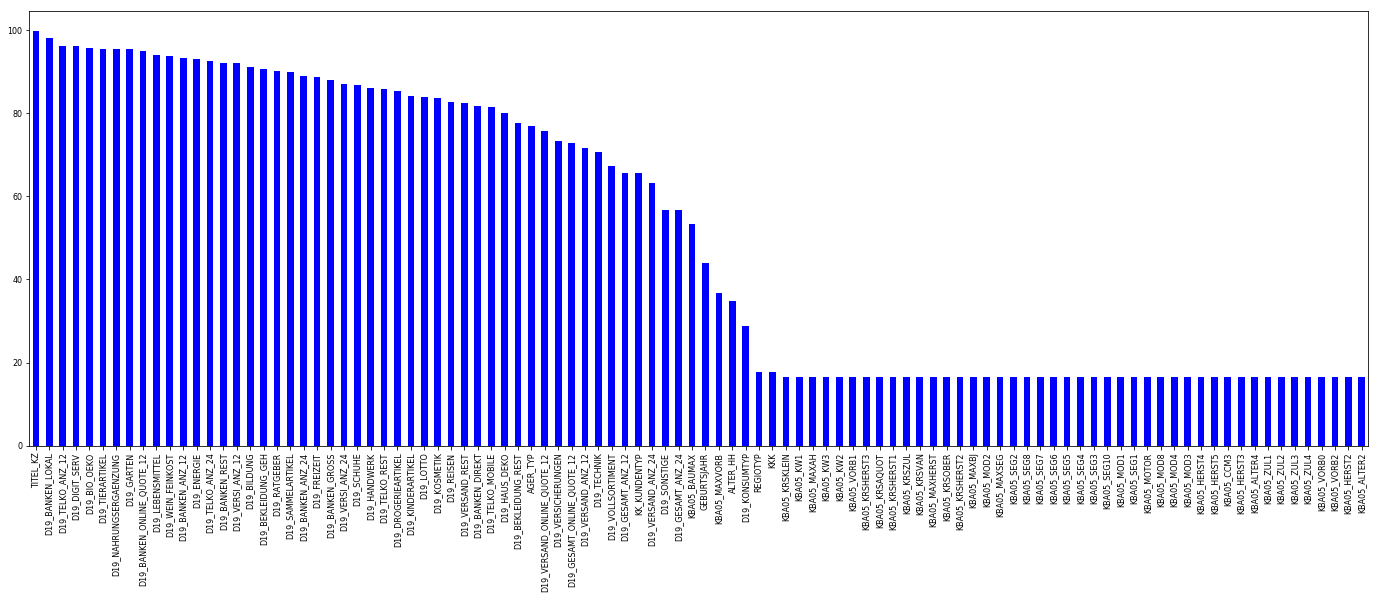

In [40]:
# Plot percentage of missing data in each column
col_dropped = azdias_dropped_columns_no_info_on.isnull().sum()
col_null_updated = col_dropped[col_dropped != 0]
(col_null_updated/azdias_dropped_columns_no_info_on.shape[0]*100).sort_values(ascending=False).head(100).plot.bar(figsize=(24,8), fontsize=8, color='b');

In [35]:
#test
azdias_dropped_columns_no_info_on['CAMEO_DEUG_2015'][2511]

nan

In [41]:
# Compare list of columns missing more than 30% and 40% of data 
to_drop_30 = [column for column in azdias_dropped_columns_no_info_on.columns if (azdias_dropped_columns_no_info_on[column].isnull().sum()/azdias_dropped_columns_no_info_on.shape[0]) * 100 > 30]
to_drop_40 = [column for column in azdias_dropped_columns_no_info_on.columns if (azdias_dropped_columns_no_info_on[column].isnull().sum()/azdias_dropped_columns_no_info_on.shape[0]) * 100 > 40]
print(len(to_drop_40), to_drop_40)
print(len(to_drop_30), to_drop_30)

51 ['AGER_TYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSAND_REST', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
53 ['AGER_TYP', 'A

'AGER_TYP' is types of eldery people, 'GEBURTSJAHR' is a year of birth, 'TITEL_KZ' is a title, 'ALTER_HH' is birthdate of head of household, 'KK_KUNDENTYP' is consumer pattern over past 12 months and 'KBA05_BAUMAX' - most common building type. And again banking activity columns. 

In [42]:
# Drop columns missing more than 30% of data
azdias_col_clean = azdias_dropped_columns_no_info_on.drop(to_drop_30, axis=1)

In [43]:
azdias_col_clean.shape

(891221, 262)

In [44]:
# Now rows with missing data
rows_null = azdias_col_clean.isnull().sum(axis=1)
rows_null.describe()

count    891221.000000
mean         28.069824
std          65.479406
min           0.000000
25%           0.000000
50%           0.000000
75%           4.000000
max         219.000000
dtype: float64

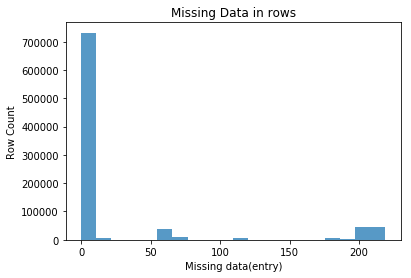

In [45]:
# Plot missing data in rows
plt.hist(rows_null, bins=20, alpha=0.75)
plt.xlabel('Missing data(entry)')
plt.ylabel('Row Count')
plt.title('Missing Data in rows')
plt.grid(False)
plt.show()

In [46]:
pct =round(len(rows_null[rows_null == 0])/(azdias_col_clean.shape[0])*100,2)
print("Percentage of complete rows: {}%".format(pct))
print(round(len(rows_null[rows_null >= 50])/(azdias_col_clean.shape[0])*100,2))
print(round(len(rows_null[rows_null >= 65])/(azdias_col_clean.shape[0])*100,2))
print(round(len(rows_null[rows_null >= 100])/(azdias_col_clean.shape[0])*100,2))

Percentage of complete rows: 54.63%
17.27
13.32
11.87


In [47]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
low_null = azdias_col_clean[azdias_col_clean.isnull().sum(axis=1) < 65]
high_null = azdias_col_clean[azdias_col_clean.isnull().sum(axis=1) >= 65]

In [44]:
#low_null.to_csv('az_subset.csv', sep=',')

In [48]:
col_to_compare = list(np.random.choice(low_null.columns, 4))
#col_to_compare = ['LP_STATUS_GROB', 'FINANZ_ANLEGER', 'SOHO_KZ', 'LP_FAMILIE_GROB', 'KONSUMNAEHE', 'RETOURTYP_BK_S', 'KBA05_MOTOR']

In [49]:
def show_plot(column):
    
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    sns.countplot(x=low_null[column], data = low_null, color='lightgreen')
    plt.title('Data to keep')
    
    plt.subplot(122)
    sns.countplot(x=high_null[column], data = high_null, color='grey')
    plt.title('Data to drop')
    
    plt.suptitle(column)
    
    plt.show()

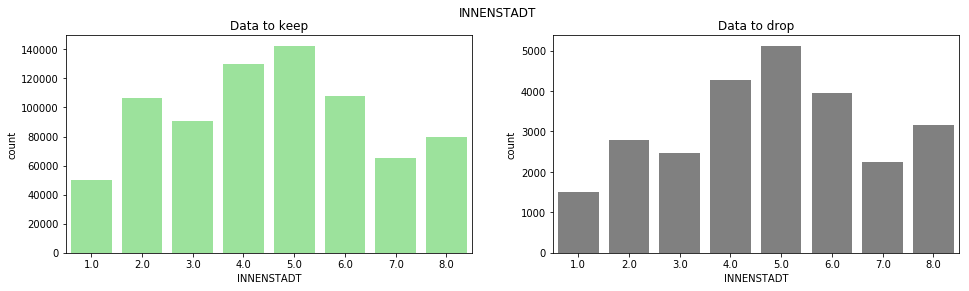

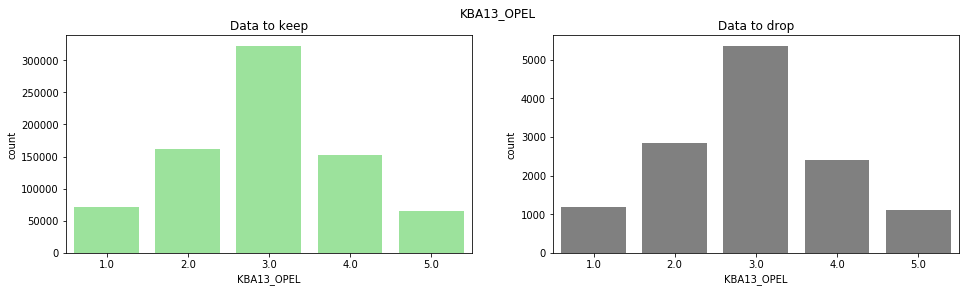

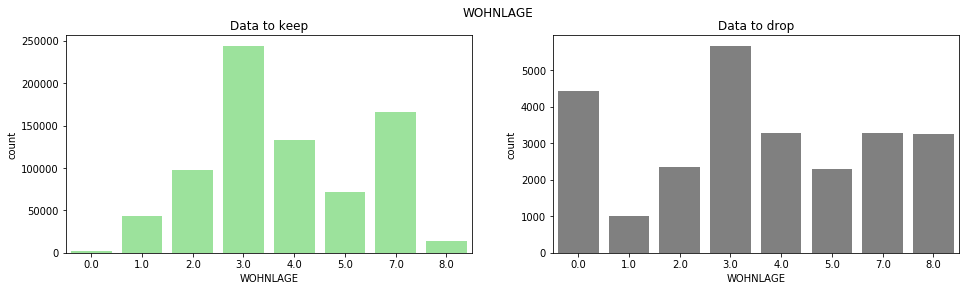

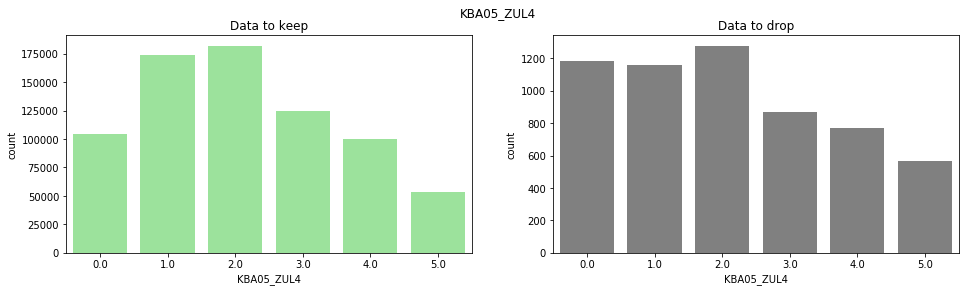

In [50]:
for column in col_to_compare:
    show_plot(column)


As we can see above the percentage of complete rows is 54.63%. Rows missing more than 50 values account for 17.27% of the data, and missing more than 65 for 13.32%. I decided to split the data set by rows missing 65 and more values. In that case we will lose only 13.32% of the data. To see how related two new subsets are to each other are I randomly choose columns and compare them.

We can see a nice correlation. Unfortunately, it is not always a case. Therefore we can be sure what for some important features as a region or a wealth, life stage and status we will have the same picture with only 86.68% of the data. But we might introduce a bias for some others.



In [51]:
low_null.select_dtypes(include=['object']).head(1)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
1,8A,8,51,W


In [52]:
# from Term 1
drop_multi =['FINANZTYP', 'GEBAEUDETYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN','CAMEO_DEU_2015']
low_null = low_null.drop(drop_multi, axis=1)

In [15]:
# Help functions from Term 1
# make an interval-type variable for decade
def add_decade(x):
    if x in (1,2):
        return 1
    if x in (3,4):
        return 2
    if x in (5,6,7):
        return 3
    if x in (8,9):
        return 4
    if x in (10,11,12,13):
        return 5
    if x in (14,15):
        return 6
    
# make a binary variable for movement, 0 - mainstream, 1- avantgarde
def add_movement(x):
    if x in (1,3,5,8,10,12,14):
        return 0
    if x in (2,4,6,7,9,11,13,15): 
        return 1

In [54]:
low_null['DECADE'] = low_null['PRAEGENDE_JUGENDJAHRE'].apply(add_decade)
low_null['MOVEMENT'] = low_null['PRAEGENDE_JUGENDJAHRE'].apply(add_movement)

In [16]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def add_wealth(x):
    if pd.isnull(x):
        return x
    else:
        return int(str(x)[0])
def add_life_stage(x):
    if pd.isnull(x):
        return x
    else:
        return int(str(x)[1])

In [56]:
low_null['CAMEO_INTL_2015_WEALTH'] = low_null['CAMEO_INTL_2015'].apply(add_wealth)
low_null['CAMEO_INTL_2015_LIFE_STAGE'] = low_null['CAMEO_INTL_2015'].apply(add_life_stage)

In [57]:
low_null['OST_WEST_KZ']=low_null['OST_WEST_KZ'].map({'W': 1, 'O': 0})
low_null = pd.get_dummies(low_null, columns = ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 
                                               'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015'])


In [59]:
low_null = low_null.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis = 1)

In [60]:
low_null.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,...,ZABEOTYP_6.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,11.0,0.0,2.0,0.0,3.0,6.0,5.0,5.0,2.0,3.0,...,0,0,0,0,0,0,0,0,1,0
2,10.0,0.0,1.0,0.0,3.0,2.0,4.0,4.0,1.0,3.0,...,0,0,0,0,1,0,0,0,0,0
3,1.0,0.0,0.0,0.0,2.0,4.0,2.0,2.0,4.0,4.0,...,0,0,1,0,0,0,0,0,0,0
4,3.0,0.0,4.0,0.0,4.0,2.0,3.0,3.0,3.0,4.0,...,0,0,0,0,0,0,1,0,0,0
5,5.0,0.0,1.0,0.0,2.0,6.0,2.0,1.0,5.0,5.0,...,0,0,0,0,0,0,0,0,1,0


In [61]:
np.unique(low_null.dtypes.values)


array([dtype('uint8'), dtype('int64'), dtype('float64')], dtype=object)

In [40]:
# Cleaning function
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    #feat_info_all.set_index('attribute', inplace=True)
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for column in df.columns:
        if column in feat_info_all.index:
            df[column] = df[column].replace(convert_to_types(feat_info_all.loc[column].missing_or_unknown), np.nan)
        elif df[column].dtype == np.int64:
            df[column]= df[column].astype(np.float64)
        else:
            continue  
        
    to_drop_no_info_columns = ['MOBI_RASTER', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'STRUKTURTYP', 'UMFELD_ALT',
                               'D19_KONSUMTYP_MAX', 'ANZ_STATISTISCHE_HAUSHALTE', 'ALTER_KIND3', 'GEMEINDETYP',
                               'VHA', 'KBA13_GBZ', 'FIRMENDICHTE', 'RT_SCHNAEPPCHEN', 'D19_VERSI_ONLINE_QUOTE_12',
                               'KBA13_CCM_1401_2500', 'DSL_FLAG', 'AKT_DAT_KL', 'KOMBIALTER', 
                               'D19_VERSI_ONLINE_DATUM', 'KBA13_BAUMAX', 'KBA13_ANTG2', 'D19_BUCH_CD',
                               'ALTER_KIND1', 'D19_VERSI_DATUM', 'EINGEFUEGT_AM', 'KBA13_ANTG1',
                               'RT_UEBERGROESSE', 'D19_TELKO_ONLINE_QUOTE_12', 'VERDICHTUNGSRAUM', 'LNR',
                               'D19_SOZIALES', 'KBA13_ANTG3', 'VK_DHT4A', 'VK_ZG11', 'KBA13_ANTG4', 'VHN',
                               'ALTER_KIND2', 'ANZ_KINDER', 'D19_VERSI_OFFLINE_DATUM', 'UNGLEICHENN_FLAG',
                               'ALTERSKATEGORIE_FEIN', 'RT_KEIN_ANREIZ', 'KBA13_KMH_210', 
                               'D19_LETZTER_KAUF_BRANCHE', 'ALTER_KIND4', 'KONSUMZELLE', 'UMFELD_JUNG',
                               'HH_DELTA_FLAG', 'VK_DISTANZ', 'KBA13_HHZ', 'CJT_KATALOGNUTZER']    
            
    to_drop_30 = ['AGER_TYP', 'ALTER_HH', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT',
                  'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST',
                  'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_DIGIT_SERV',
                  'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12',
                  'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
                  'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
                  'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK',
                  'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
                  'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSAND_REST',
                  'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT',
                  'D19_WEIN_FEINKOST', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'TITEL_KZ']
    
    to_drop_multi = ['FINANZTYP', 'GEBAEUDETYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN','CAMEO_DEU_2015']
    
    multi_to_dummies = ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
                       'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015']
    

    # remove selected columns and rows, ...
    
    df = df.drop(to_drop_no_info_columns, axis=1)
    df = df.drop(to_drop_30, axis=1)
              
    df = df[df.isnull().sum(axis=1) < 65]
    df = df.drop(to_drop_multi, axis=1)
    
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    df = pd.get_dummies(df, columns=multi_to_dummies)
    
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(add_decade)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(add_movement)

    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(add_wealth)
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(add_life_stage)
    
    df = df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis = 1)
    
    # Return the cleaned dataframe.
    return df
    

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [18]:
azdias_clean = clean_data(azdias)
#azdias_clean = low_null.copy()
azdias_clean.shape

(772523, 301)

In [19]:
feat_info_all.to_csv('feature_all.csv', sep=',')

In [20]:
azdias_clean.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,11.0,0.0,2.0,0.0,3.0,6.0,5.0,5.0,2.0,3.0,...,0,0,0,0,1,0,6.0,0.0,5.0,1.0
2,10.0,0.0,1.0,0.0,3.0,2.0,4.0,4.0,1.0,3.0,...,1,0,0,0,0,0,6.0,1.0,2.0,4.0
3,1.0,0.0,0.0,0.0,2.0,4.0,2.0,2.0,4.0,4.0,...,0,0,0,0,0,0,4.0,0.0,1.0,2.0
4,3.0,0.0,4.0,0.0,4.0,2.0,3.0,3.0,3.0,4.0,...,0,0,1,0,0,0,4.0,0.0,4.0,3.0
5,5.0,0.0,1.0,0.0,2.0,6.0,2.0,1.0,5.0,5.0,...,0,0,0,0,1,0,2.0,0.0,5.0,4.0


In [21]:
# Apply Imputer and StandardScaler to be able to use PCA analysis later

imputer = Imputer(strategy='most_frequent')
azdias_imputed = imputer.fit_transform(azdias_clean)

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imputed)


In [22]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

In [23]:
# From Term 1
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=8)
 
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

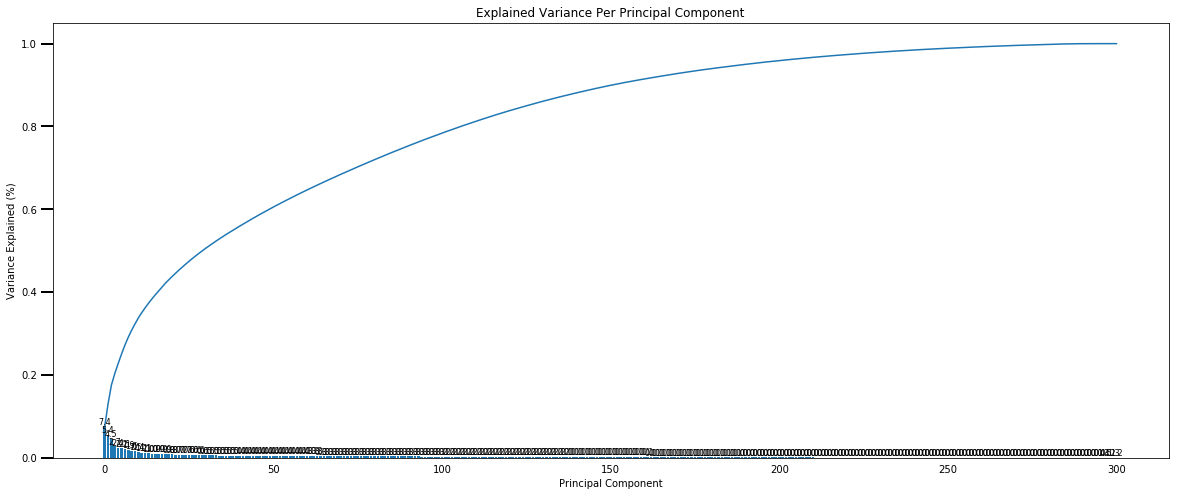

In [24]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [25]:
# Find the percentage of data explained by number of principal components
first_120 = round(pca.explained_variance_ratio_[:120].sum(),2)
first_150 = round(pca.explained_variance_ratio_[:150].sum(),2)
first_200 = round(pca.explained_variance_ratio_[:200].sum(),2)
first_131 = round(pca.explained_variance_ratio_[:131].sum(),2)
print(first_131, first_200, first_150, first_120)

0.86 0.96 0.9 0.84


In [27]:
# Apply PCA to the data.
pca = PCA(131)
azdias_pca = pca.fit_transform(azdias_scaled)

In [28]:
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.columns)
    components.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

    

def plot_dim(pca_results, pca, dim):
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))
    
    # Plot the feature weights as a function of the components
    dim_name = 'Dimension ' + str(dim)
    dim_ratio = round(pca_results(azdias_clean, pca).loc[dim_name][0]*100,2)
    
    components = pca_results(azdias_clean, pca).loc[dim_name][1:].sort_values(ascending=False)
    components_ = pd.concat([components.head(6), components.tail(6)])
    components_.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    plt.suptitle("{}: {}% Variance Explained".format(dim_name, dim_ratio), fontsize=18)


    plt.show()

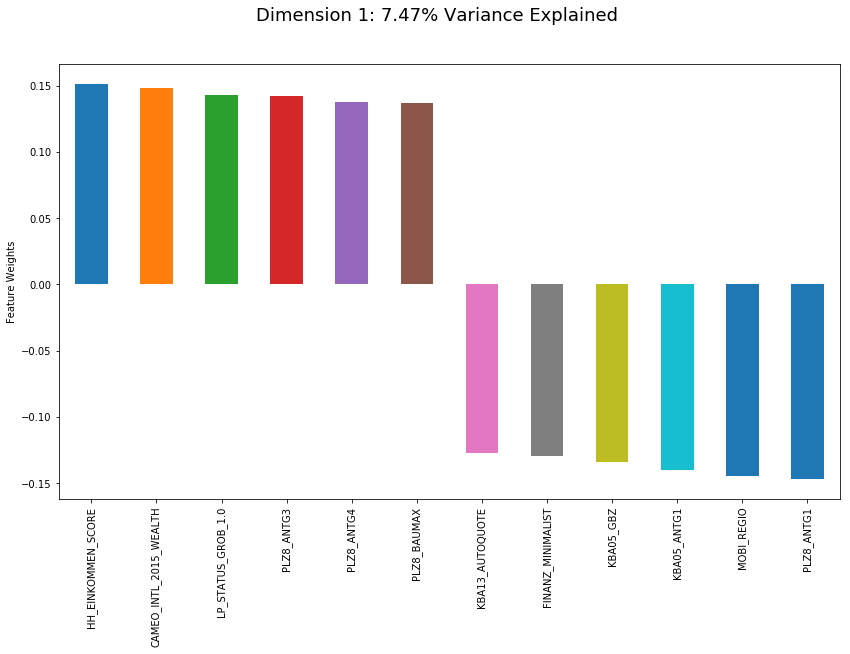

,Explained Variance,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
Dimension 1,0.0747,0.0801,0.0119,-0.0649,-0.0064,0.1112,-0.0535,0.0611,0.0817,-0.0710,...,-0.0534,-0.0179,0.0025,0.0224,0.0736,0.0938,0.0491,-0.0949,0.1486,-0.0846
Dimension 2,0.0548,0.0468,0.0309,-0.0319,0.0093,-0.0063,-0.1098,0.0527,0.0710,-0.0693,...,-0.0322,0.0220,-0.0112,0.0118,0.0128,0.0224,0.0417,0.0461,0.0217,-0.0313
Dimension 3,0.0460,0.0319,0.0220,-0.0638,0.0076,0.0437,-0.0296,-0.2048,-0.2002,0.1697,...,-0.0295,-0.0029,0.0121,0.0053,0.0269,0.0058,-0.2128,0.0098,0.0342,0.0230
Dimension 4,0.0278,0.0051,0.0152,0.0986,0.0124,0.1297,-0.0301,0.0009,0.0048,-0.0185,...,-0.0364,-0.0000,0.0078,-0.0039,0.0162,-0.0268,0.0081,0.0959,-0.0148,0.0569
Dimension 5,0.0242,-0.0034,-0.0021,0.1346,0.0078,0.0041,-0.0918,-0.0509,-0.0375,0.0223,...,-0.0043,-0.0042,-0.0142,-0.0034,0.0088,0.0273,-0.0441,0.0759,0.0154,-0.0317


In [29]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
plot_dim(pca_results, pca, 1)
pca_results(azdias_clean, pca).head()

## Dimension 1:

### Positive


 HH_EINKOMMEN_SCORE - is net income score (1 - is highest, and 6-lowest)
 
 
 LP_STATUS_GROB -social status rough (1 - low-income, 7-8 - houseowners, 10 - top-earners)
 
 
 PLZ8_ANTG - share of family houses with levels of houses ANTG1 - ANTG4 (1-2, 3-5, 6-10, >10)

### Negative

 PLZ8_ANTG1 - 1-2 family houses ( from None to very high share)
 
 MOBI_REGIO - moving patterns
 
 FINANZ_MINIMALIST - low financial interest (Gfk-Typology based on a representative household panel combined via a statistical modell with AZ DIAS data). Levels: 1 - is high, 5- very low 
 


**Dimension 1 is about net income and a place of living.**

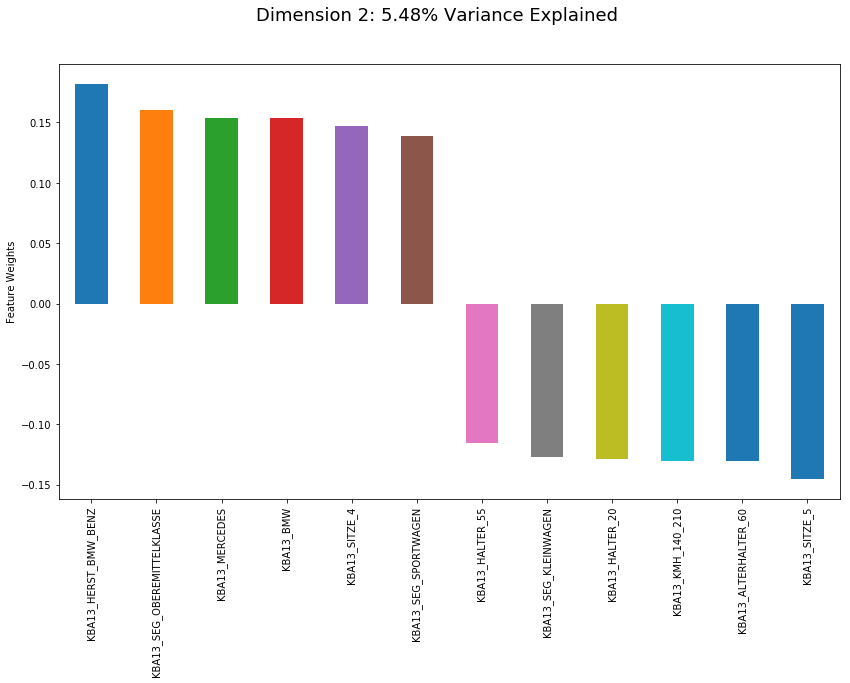

In [30]:
plot_dim(pca_results, pca, 2)

## Dimension 2:

### Positive


People who own German-made cars

### Negative 

The number of cars with 5 seats own by people under 21 y.o. or older than 50 y.o.**


**Dimension 2 is about car owners and their prefereces**

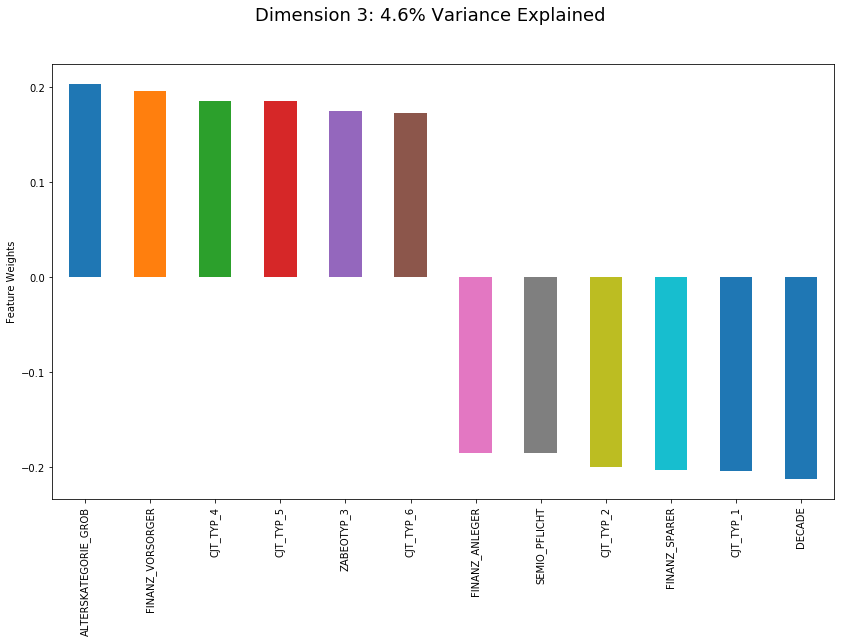

In [31]:
plot_dim(pca_results, pca, 3)

## Dimension 3:


### Positive

ALTERSKATEGORIE_GROB - age classification through prename analysis  (from 1 - <30 years to 4 - >60 years)

FINANZ_VORSORGER - Be Prepared (Gfk-Typology based on a representative household panel combined via a statistical modell with AZ DIAS data). Levels: 1 - is high, 5- very low 

CJT_TYP_4 - CJT_TYP_6 - customer journey typology ( 4: advertising interested Online-shopper, 5: Advertising- and Cross-Channel-Enthusiast, 6: Advertising-Enthusiast with restricted Cross-Channel-Behavior) 

ZABEOTYP_3 - fair supplied, typification of energy consumers


### Negative

DECADE is a part of dominating movement in the person's youth (avantgarde or mainstream) and about years of persons youth. Starting from 40ies to 90ies.

CJT_TYP_1 and CJT_TYP_2 - customer journey typology (1: Advertising- and Consumption minimalist, 2: Advertising- and Consumption traditionalist

SEMIO_PFLICHT - affinity indicating in what way the person is dutyfull traditional minded ( from 1 - highest affinity to 7- lowest affinity)


FINANZ_SPARER - Money saver (Gfk-Typology based on a representative household panel combined via a statistical modell with AZ DIAS data). Levels: 1 - is high, 5- very low 

FINANZ_ANLEGER - Investor (Gfk-Typology based on a representative household panel combined via a statistical modell with AZ DIAS data). Levels: 1 - is high, 5- very low 


**Dimension 3 is more about financial type of person - people who are ready to spend vs. people traditionally minded, money savors.**


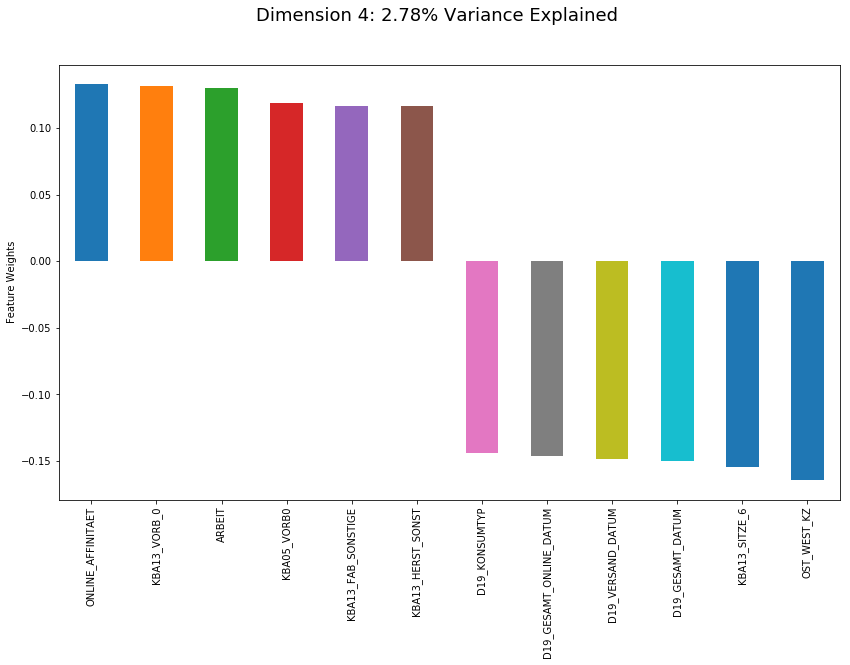

In [32]:
plot_dim(pca_results, pca, 4)

## Dimension 4:

### Positive

 ONLINE_AFFINITAET - online affinity (from low to highest)
 
 KBA13_VORB_0 - share of cars with no preowner - PLZ8, KBA5_VORB_0 - share of cars with no preowner. Levels: 1-low to 5 - very high
 
 KBA13_HERST_SONST -  share of other cars within the PLZ8. Levels: 1-low to 5 - very high
 
 KBA13_FAB_SONSTIGE  - share of other Manufacturers within the PLZ8. Levels: 1-low to 5 - very high
 
 
 ### Negative
 
 OST_WEST_KZ - flag indicating the former GDR/FRG (OST: 0, WEST: 1)
 
 D19_GESAMT_DATUM - actuality of the last transaction with the complete file TOTAL (1- highest activity within the last 12 months, 10 - elder than 3 years)
 
 D19_GESAMT_ONLINE_DATUM - actuality of the last transaction with the complete file ONLINE (1- highest activity within the last 12 months, 10 - elder than 3 years)
 
 D19_VERSAND_DATUM - actuality of the last transaction for the segment mail-order TOTAL (1- highest activity within the last 12 months, 10 - elder than 3 years)
 
 KBA13_SITZE_6 - number of cars with more than 5 seats in the PLZ8 (from none to very high)
 
 D19_KONSUMTYP - consumption type (6 - inactive)
 
**Dimension 4 is about person online active with preferences of buying new cars from not major car producers (may be the cost less), opposite is a person with very low financial activity. I'm not sure what kind of role plays WEST-OST flag.**

In [33]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [34]:
azdias_pca_sample = azdias_pca[np.random.choice(azdias_pca.shape[0], int(azdias_pca.shape[0]/4), replace=False)]

In [35]:
# Over a number of different cluster counts...
start_time = time.time()
scores = []
centers = list(range(1,16))

# run k-means clustering on the data and compute the average within-cluster distances.
for center in centers:
    scores.append(get_kmeans_score(azdias_pca_sample, center))    
    
print('Time: {} mins'.format(round((time.time() - start_time)/60,2)))    


Time: 26.75 mins


Text(0.5,1,'SSE vs. K')

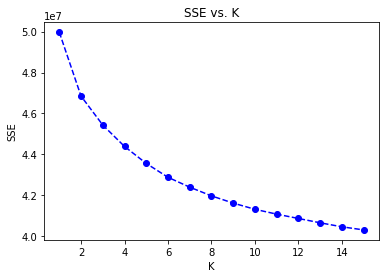

In [36]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

**Using 'elbow-method' we can safely assume that K should be between 4 and 6, after 6 distance between clusters is smaller. I decided to use K=5.**


In [37]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_5 = KMeans(n_clusters=5, random_state = 42)
model_predict = kmeans_5.fit_predict(azdias_pca)

In [38]:
# Read customers data and drop columns 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP' 
# which don't exist in general population data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)
customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)

In [41]:
# Clean customers data
customers_clean =clean_data(customers)

In [42]:
# Percentage of customers data to keep
list(set(azdias_clean.columns) - set(customers_clean))
customers_clean.shape
print(round(customers_clean.shape[0]/customers.shape[0],2))


0.72


In [43]:
# Perfom the same steps for PCA as we did for azdias

customers_imputed = imputer.fit_transform(customers_clean)

customers_scaled = scaler.fit_transform(customers_imputed)

customers_pca = pca.fit_transform(customers_scaled)

In [44]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
customers_predict = kmeans_5.fit_predict(customers_pca)



In [45]:
general_p = pd.Series(model_predict)
customers_p = pd.Series(customers_predict)

azdias_missing_p = azdias.shape[0] - azdias_clean.shape[0]
customers_missing_p = customers.shape[0]- customers_clean.shape[0]

general_clusters=general_p.value_counts().sort_index()
customer_clusters = customers_p.value_counts().sort_index()
print(general_clusters)
print(customer_clusters)
print(azdias_missing_p)

0    204381
1    166454
2    103729
3    190986
4    106973
dtype: int64
0    20674
1    31486
2    40511
3    18909
4    27167
dtype: int64
118698


In [46]:
# Adding row for cluster [-1] to represent data from high_null rows
df = pd.concat([general_clusters, customer_clusters], axis=1).reset_index()
df.columns = ['cluster', 'general', 'customer']
df.loc[-1] = ['-1', azdias_missing_p, customers_missing_p]
df.index = df.index+1
df.sort_index(inplace=True)
df


,cluster,general,customer
0,-1,118698,52905
1,0,204381,20674
2,1,166454,31486
3,2,103729,40511
4,3,190986,18909
5,4,106973,27167


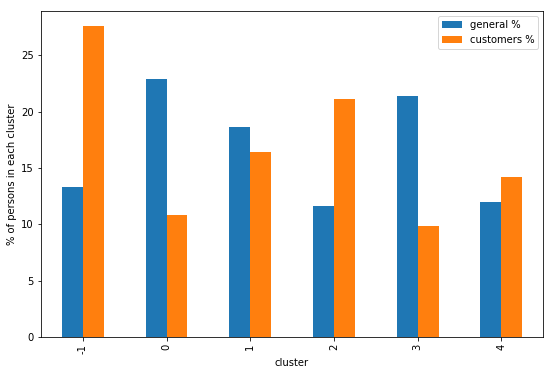

In [47]:
# Compare clusters with general and customers data
df['general %'] = round(df['general']/df['general'].sum()*100,2)
df['customers %'] = round(df['customer']/df['customer'].sum()*100,2)


df.plot(x='cluster', y = ['general %', 'customers %'], kind='bar', figsize=(9,6))
plt.ylabel('% of persons in each cluster')
plt.show()

In [48]:
# Find corresponding pca dimension for cluster 2 with customers overpresented
cl_2 = kmeans_5.cluster_centers_[2]
cl_2 = pd.Series(cl_2)
cl_2.index = cl_2.index+1
cl_2.sort_values(ascending=False)

4      1.441072
1      0.834102
5      0.191338
11     0.165981
26     0.141946
17     0.135536
18     0.109013
51     0.103206
25     0.098879
12     0.074889
36     0.061377
67     0.050258
39     0.049684
40     0.045842
55     0.045442
42     0.043569
79     0.042074
33     0.039365
30     0.038776
58     0.037709
88     0.032542
90     0.032178
63     0.028810
66     0.026546
75     0.025609
120    0.025297
99     0.024182
69     0.024097
97     0.021419
103    0.021055
         ...   
82    -0.033113
80    -0.033511
74    -0.033756
29    -0.035009
27    -0.035466
47    -0.038386
109   -0.041475
15    -0.041769
113   -0.046607
59    -0.046989
111   -0.047453
117   -0.057734
37    -0.058182
38    -0.060736
43    -0.062501
96    -0.067516
21    -0.075940
35    -0.095535
14    -0.175392
19    -0.179213
23    -0.187016
20    -0.188686
13    -0.254480
16    -0.290301
8     -0.363096
10    -0.396513
9     -0.422439
6     -0.471508
2     -1.543204
3     -1.576386
Length: 131, dtype: floa

In [52]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

c_2_c = scaler.inverse_transform(pca.inverse_transform(cl_2))
c_2_c = pd.Series(c_2_c)
c_2_c.index = azdias_clean.columns
c_2_c.head()

ANZ_HAUSHALTE_AKTIV    1.621721
ANZ_HH_TITEL           0.024668
ANZ_PERSONEN           2.388510
ANZ_TITEL              0.024985
ARBEIT                 2.908965
dtype: float64

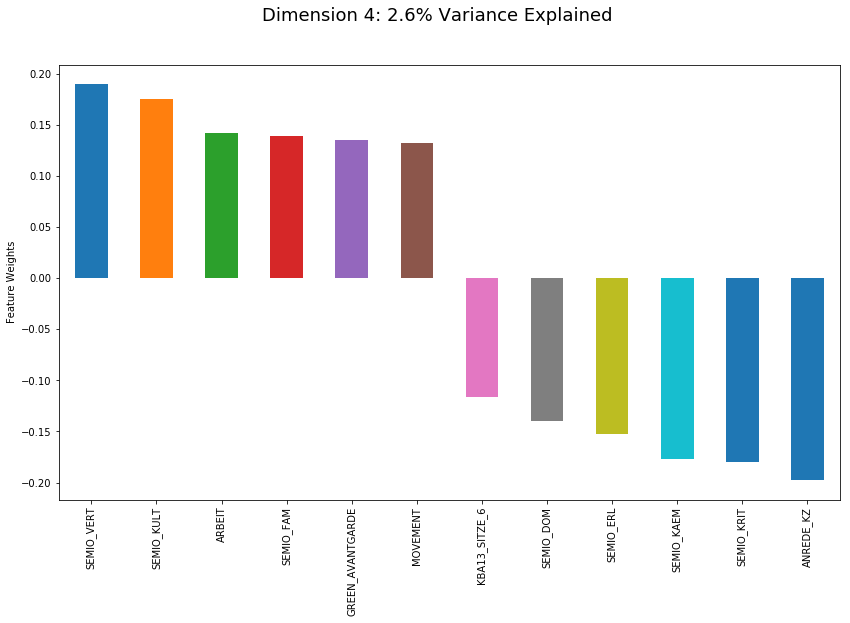

In [53]:
plot_dim(pca_results, pca, 4)

### Discussion

Person is dreamily, cultural minded, familiar minded with opposite person is critical minded, eventful orientated, dominant minded

In [54]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cl_0 = kmeans_5.cluster_centers_[0]
cl_0 = pd.Series(cl_0)
cl_0.index = cl_0.index+1
cl_0.sort_values(ascending=False) 

1      7.339935
10     0.585951
3      0.388223
13     0.358112
9      0.302368
8      0.282566
16     0.271365
5      0.213532
19     0.192763
23     0.189277
38     0.128504
24     0.123842
43     0.116032
21     0.112056
35     0.067271
111    0.066206
37     0.065485
96     0.060246
25     0.057883
82     0.056408
56     0.055107
113    0.054596
47     0.054169
110    0.049765
53     0.049618
117    0.046587
71     0.045883
109    0.045390
45     0.044450
94     0.041886
         ...   
126   -0.027275
101   -0.027823
85    -0.027860
61    -0.027977
55    -0.030855
99    -0.030995
42    -0.035303
78    -0.035447
63    -0.037917
27    -0.039264
83    -0.041414
52    -0.042820
116   -0.044577
84    -0.045155
115   -0.053920
48    -0.057830
11    -0.058312
39    -0.059724
30    -0.065460
44    -0.067273
18    -0.067333
51    -0.076351
33    -0.094584
36    -0.097300
26    -0.165965
17    -0.189806
14    -0.203356
2     -0.248328
12    -0.284964
4     -0.345816
Length: 131, dtype: floa

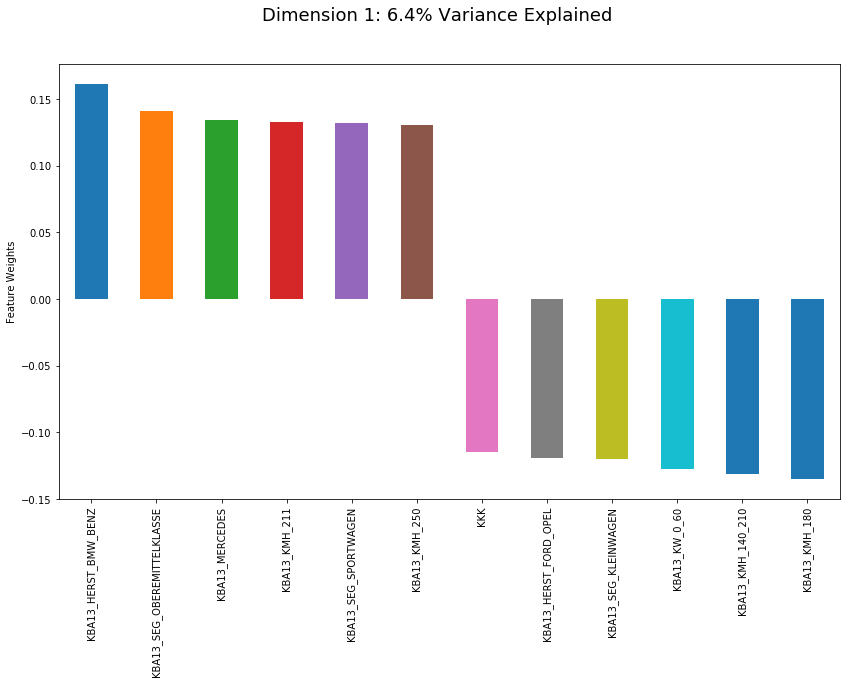

In [55]:
plot_dim(pca_results, pca, 1)

### Discussion

Person who ownes upper middle class cars and upper class cars (BMW5er, BMW7er etc.), sports cars

In [56]:
cl_3 = kmeans_5.cluster_centers_[3]
cl_3 = pd.Series(cl_3)
cl_3.index = cl_3.index+1
cl_3.sort_values(ascending=False) 

3      5.458328
5      0.647577
17     0.332237
19     0.322402
34     0.186382
33     0.181502
18     0.162781
32     0.156914
12     0.155802
10     0.153339
27     0.132459
46     0.117904
7      0.100131
44     0.096274
38     0.087904
31     0.078718
47     0.074584
29     0.073859
40     0.072726
70     0.071257
50     0.068901
37     0.066515
49     0.064360
43     0.063684
42     0.055813
51     0.054968
58     0.049385
117    0.048932
97     0.047646
82     0.046613
         ...   
118   -0.041594
59    -0.042345
56    -0.043528
120   -0.044205
23    -0.044383
53    -0.045348
79    -0.045585
14    -0.057794
76    -0.060004
62    -0.060633
26    -0.067781
16    -0.068389
66    -0.082674
24    -0.085235
92    -0.086739
75    -0.090726
110   -0.098226
21    -0.107563
22    -0.118748
15    -0.126807
9     -0.130829
41    -0.151872
20    -0.171751
11    -0.206710
45    -0.212221
6     -0.408154
13    -0.464448
8     -0.849552
2     -1.066433
1     -1.785470
Length: 131, dtype: floa

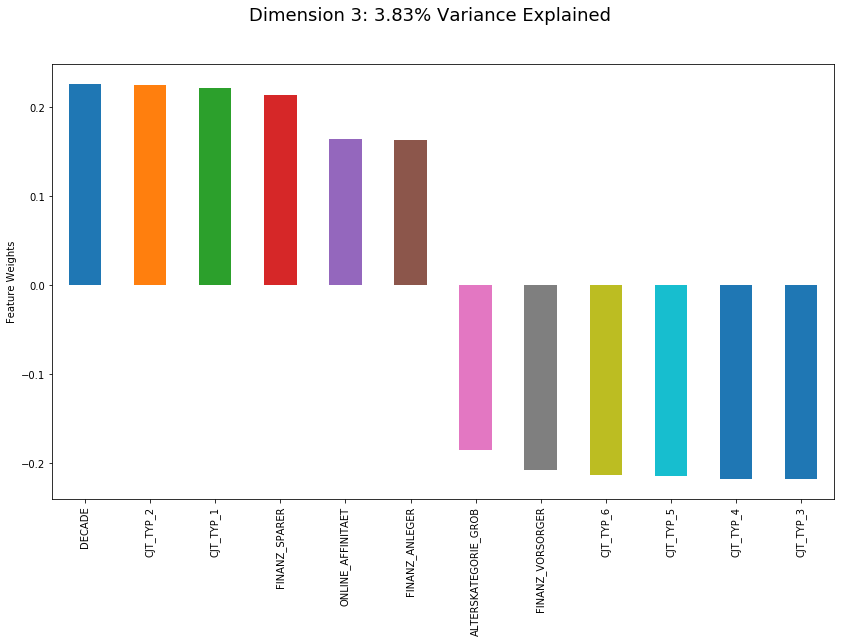

In [57]:
plot_dim(pca_results, pca, 3)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [58]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)

In [59]:
# Find percentage of success for a mail-out campaing 
n_yes = mailout_train[mailout_train['RESPONSE'] == 1].shape[0]
n_no = mailout_train[mailout_train['RESPONSE'] == 0].shape[0]
success_rate = round(n_yes/ mailout_train.shape[0] * 100, 2)
print('Success rate for a mail-out campaign is {}%'.format(success_rate))


Success rate for a mail-out campaign is 1.24%


In [3]:
feat_info_all = pd.read_csv('feature_all.csv', sep=',')

def is_valid_decimal(s):
    try:
        int(s)
    except ValueError:
        return False
    else:
        return True
    
def convert_to_types(source):
    return list(map(lambda x: int(x) if is_valid_decimal(x) else x, source[1:-1].split(',')))


def add_decade(x):
    if x in (1,2):
        return 1
    if x in (3,4):
        return 2
    if x in (5,6,7):
        return 3
    if x in (8,9):
        return 4
    if x in (10,11,12,13):
        return 5
    if x in (14,15):
        return 6
    
# make a binary variable for movement, 0 - mainstream, 1- avantgarde
def add_movement(x):
    if x in (1,3,5,8,10,12,14):
        return 0
    if x in (2,4,6,7,9,11,13,15): 
        return 1
    
    
def add_wealth(x):
    if pd.isnull(x):
        return x
    else:
        return int(str(x)[0])

def add_life_stage(x):
    if pd.isnull(x):
        return x
    else:
        return int(str(x)[1])
    

In [100]:
def clean_data_kaggle(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    #feat_info_all.set_index('attribute', inplace=True)
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for column in df.columns:
        if column in feat_info_all.index:
            df[column] = df[column].replace(convert_to_types(feat_info_all.loc[column].missing_or_unknown), np.nan)
        elif df[column].dtype == np.int64:
            df[column]= df[column].astype(np.float64)
        else:
            continue  
        
    to_drop_no_info_columns = ['MOBI_RASTER', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'STRUKTURTYP', 'UMFELD_ALT',
                               'D19_KONSUMTYP_MAX', 'ANZ_STATISTISCHE_HAUSHALTE', 'ALTER_KIND3', 'GEMEINDETYP',
                               'VHA', 'KBA13_GBZ', 'FIRMENDICHTE', 'RT_SCHNAEPPCHEN', 'D19_VERSI_ONLINE_QUOTE_12',
                               'KBA13_CCM_1401_2500', 'DSL_FLAG', 'AKT_DAT_KL', 'KOMBIALTER', 
                               'D19_VERSI_ONLINE_DATUM', 'KBA13_BAUMAX', 'KBA13_ANTG2', 'D19_BUCH_CD',
                               'ALTER_KIND1', 'D19_VERSI_DATUM', 'EINGEFUEGT_AM', 'KBA13_ANTG1',
                               'RT_UEBERGROESSE', 'D19_TELKO_ONLINE_QUOTE_12', 'VERDICHTUNGSRAUM', 'LNR',
                               'D19_SOZIALES', 'KBA13_ANTG3', 'VK_DHT4A', 'VK_ZG11', 'KBA13_ANTG4', 'VHN',
                               'ALTER_KIND2', 'ANZ_KINDER', 'D19_VERSI_OFFLINE_DATUM', 'UNGLEICHENN_FLAG',
                               'ALTERSKATEGORIE_FEIN', 'RT_KEIN_ANREIZ', 'KBA13_KMH_210', 
                               'D19_LETZTER_KAUF_BRANCHE', 'ALTER_KIND4', 'KONSUMZELLE', 'UMFELD_JUNG',
                               'HH_DELTA_FLAG', 'VK_DISTANZ', 'KBA13_HHZ', 'CJT_KATALOGNUTZER']    
            
    to_drop_30 = ['AGER_TYP', 'ALTER_HH', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT',
                  'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST',
                  'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_DIGIT_SERV',
                  'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12',
                  'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
                  'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
                  'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK',
                  'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
                  'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSAND_REST',
                  'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT',
                  'D19_WEIN_FEINKOST', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'TITEL_KZ']
    
    to_drop_multi = ['FINANZTYP', 'GEBAEUDETYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN','CAMEO_DEU_2015']
    
    multi_to_dummies = ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
                       'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015']
    

    # remove selected columns and rows, ...
    
    df = df.drop(to_drop_no_info_columns, axis=1)
    df = df.drop(to_drop_30, axis=1)
              
    #df = df[df.isnull().sum(axis=1) < 65]
    df = df.drop(to_drop_multi, axis=1)
    
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    df = pd.get_dummies(df, columns=multi_to_dummies)
    
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(add_decade)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(add_movement)

    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(add_wealth)
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(add_life_stage)
    
    df = df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis = 1)
    
    # Return the cleaned dataframe.
    return df

In [60]:
#Clean mailout_train data
train = clean_data(mailout_train)

In [61]:
train.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,15.0,0.0,1.0,0.0,3.0,5.0,2.0,2.0,5.0,5.0,...,0,1,0,0,0,0,1.0,0.0,3.0,4.0
1,1.0,0.0,2.0,0.0,2.0,5.0,2.0,2.0,4.0,3.0,...,0,1,0,0,0,0,4.0,0.0,3.0,2.0
2,NaN,NaN,0.0,0.0,4.0,1.0,1.0,1.0,5.0,5.0,...,0,0,0,0,0,0,1.0,1.0,1.0,4.0
3,4.0,0.0,2.0,0.0,4.0,2.0,2.0,2.0,5.0,5.0,...,0,0,0,0,0,0,1.0,1.0,1.0,4.0
4,53.0,0.0,1.0,0.0,3.0,4.0,1.0,2.0,5.0,5.0,...,0,0,0,1,0,0,2.0,0.0,4.0,1.0


In [62]:
train['RESPONSE'].shape

(34733,)

In [63]:
# Separate and keep 'Response' column as labels file and the rest as training data file 
y_response = train['RESPONSE']
train_data = train.drop(['RESPONSE'], axis=1)

In [64]:
y_response.shape, train.shape
#train.head()

((34733,), (34733, 302))

In [55]:
# test
test = pd.DataFrame(X_train_scaled)
test.head()

,0,1,2,3,4,5,6,7,8,9,...,288,289,290,291,292,293,294,295,296,297
0,-0.939391,1.958001,-0.128754,-1.485619,-0.091669,-0.046364,-1.483349,0.441085,0.19825,0.342219,...,-0.411761,-0.276482,-0.426488,-0.308527,2.427173,-0.272351,-1.309790,-0.729448,1.398091,-1.601745
1,-0.450065,-0.380491,-0.128754,-1.485619,-0.091669,-1.016034,0.791915,0.441085,0.19825,0.342219,...,-0.411761,-0.276482,-0.426488,-0.308527,-0.412002,-0.272351,-0.577161,-0.729448,-1.346427,0.509725
2,-0.694728,-0.313677,-0.128754,-0.018930,-0.091669,-1.016034,0.791915,0.441085,0.19825,0.342219,...,2.428595,-0.276482,-0.426488,-0.308527,-0.412002,-0.272351,-0.577161,1.370899,-0.660297,-0.897921
3,-0.450065,-0.380491,-0.128754,0.714414,-0.091669,-1.985704,0.791915,0.441085,0.19825,0.342219,...,-0.411761,-0.276482,2.344730,-0.308527,-0.412002,-0.272351,-0.577161,-0.729448,0.711961,0.509725
4,-0.694728,-0.313677,-0.128754,-0.018930,-0.091669,-0.046364,-0.118191,0.441085,0.19825,0.342219,...,-0.411761,-0.276482,-0.426488,-0.308527,2.427173,-0.272351,-1.309790,-0.729448,1.398091,1.213548


In [93]:
 
params = {}

def roc_score_and_best_model(clf, params, X=train_data, y=y_response):
    """
    Build Pipeline for imputing, scaling data and classifier, perform a 
    Grid search using GridSearchCV on Pipeline with given parameters
    
    INPUT: classifier, parameters 
    OUTPUT: GridSearch best estimator 
    """
    pipeline = Pipeline([('imp', Imputer(strategy='most_frequent')),
                         ('scaler', StandardScaler()),('clf', clf)])
                            
    grid = GridSearchCV(estimator=pipeline, param_grid=params, scoring='roc_auc', cv=5, n_jobs=-1)

    grid.fit(train_data,y_response)
    
    
    print("Best score is: {}".format(round(grid.best_score_, 4)), grid.best_params_)
    
    return grid.best_estimator_   


In [83]:
%%time
# RandomForestClassifier
roc_score_and_best_model(RandomForestClassifier(random_state=42), params)

Best score is: 0.5177
CPU times: user 12.7 s, sys: 3.44 s, total: 16.1 s
Wall time: 16.2 s


Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_feature...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [84]:
%%time
# GradientBoostingClassifier
roc_score_and_best_model(GradientBoostingClassifier(random_state=42), params)

Best score is: 0.631
CPU times: user 3min 29s, sys: 4.14 s, total: 3min 34s
Wall time: 3min 34s


Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', m...        presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False))])

In [68]:
%%time
# GradientBoostingRegressor
roc_score_and_best_model(GradientBoostingRegressor(random_state=42), params)

Best score is: 0.6161 {}
CPU times: user 3min 28s, sys: 3.68 s, total: 3min 32s
Wall time: 3min 33s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls'...ors=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [85]:
%%time
# AdaBoostClassifier
roc_score_and_best_model(AdaBoostClassifier(random_state=42), params)

Best score is: 0.6115
CPU times: user 1min 13s, sys: 3.68 s, total: 1min 16s
Wall time: 1min 17s


Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42))])

In [96]:
%%time
params = {'clf__learning_rate' : [0.5, 0.1],
          'clf__n_estimators' : [50, 70, 100]           
         }

AdaBoost_model = roc_score_and_best_model(AdaBoostClassifier(random_state=42), params)

Best score is: 0.6297 {'clf__learning_rate': 0.5, 'clf__n_estimators': 50}
CPU times: user 8min 40s, sys: 19.6 s, total: 9min
Wall time: 9min 2s


In [119]:
%%time
params = {'clf__learning_rate' : [0.1],
          'clf__n_estimators' : [100],
          'clf__min_samples_split': [6],
          'clf__max_depth' : [3, 5]
         }

GradientBoost_model = roc_score_and_best_model(GradientBoostingClassifier(random_state=42), params)

Best score is: 0.6333 {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__min_samples_split': 6, 'clf__n_estimators': 100}
CPU times: user 11min 14s, sys: 7.13 s, total: 11min 21s
Wall time: 11min 23s


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [98]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)

In [101]:
# Save 'LNR' column to new dataframe and clean test data
test_LNR = mailout_test['LNR']
mailout_test_clean = clean_data_kaggle(mailout_test) 


In [125]:
# Fit AdaBoostClassifier model
AdaBoost_model.fit(train_data, y_response)

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=42))])

In [120]:
# Fit GradientBoostingClassifier model
GradientBoost_model.fit(train_data, y_response)

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', m...        presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False))])

In [124]:
# Predict on AdaBoostClassifier model
predictions = AdaBoost_model.predict_proba(mailout_test_clean)
predictions[:7]

array([[ 0.5387795 ,  0.4612205 ],
       [ 0.53969185,  0.46030815],
       [ 0.55735865,  0.44264135],
       [ 0.56671511,  0.43328489],
       [ 0.54780597,  0.45219403],
       [ 0.56004536,  0.43995464],
       [ 0.5381109 ,  0.4618891 ]])

In [123]:
# Predict on GradientBoostingClassifier model
predictions_1 = GradientBoost_model.predict_proba(mailout_test_clean)
predictions[:-10]

array([[ 0.97721388,  0.02278612],
       [ 0.97887382,  0.02112618],
       [ 0.9950181 ,  0.0049819 ],
       ..., 
       [ 0.99723175,  0.00276825],
       [ 0.99415057,  0.00584943],
       [ 0.9883441 ,  0.0116559 ]])

In [126]:
submission = pd.DataFrame({'LNR': test_LNR, 'RESPONSE': predictions[:,1]})
submission.to_csv('submission_kaggle.csv', sep=',')

submission.head()

,LNR,RESPONSE
0,1754,0.461221
1,1770,0.460308
2,1465,0.442641
3,1470,0.433285
4,1478,0.452194


In [128]:
submission_GB = pd.DataFrame({'LNR': test_LNR, 'RESPONSE': predictions_1[:,1]})
submission_GB.to_csv('submission_kaggle_1.csv', sep=',')

submission_GB.head()

,LNR,RESPONSE
0,1754,0.022786
1,1770,0.021126
2,1465,0.004982
3,1470,0.009077
4,1478,0.003420


**Predictions in GradientBoostingClassifier model look more close to reality to me than those with AdaBoost model. For that reason I decided to submit GradientBoostingClassifier model predictions.**

**I think there is plenty of options for improvment - I could try to optimize GradientBoostingClassifier better or try another Classifier. Unfortunately, it was very time consuming to do so. I see a potential to improve Data cleaning, some columns like ANZ_TITEL might be dropped, may be combining columns for car types and etc. Overwise it was quite a challenging project for me but I was able to do it and this is the best part.**